## "Мобильные приложения - Выделение групп пользователей на основе поведения"

**Ссылка на дашборды:** https://public.tableau.com/views/Final_project_practicum/Dashboard_set_2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

________


## Декомпозиция задачи проекта

#### 1. Предобработка данных

- [x] Проверить и исправить оформление датасетов
- [x] Проверить данные на пропуски, дубликаты (при необходимости исправить)
- [x] Проверить данные на аномалии (при необходимости исправить)
- [x] Объединить одинаковые события с разными наименованиями

#### 2. Исследовательский анализ данных

- [x] Составить профили пользователей: id, источник, время первого посещения, дата первого посещения
- [x] Выделить сессии пользователей, добавить в датасет колонки `начало сессии` и `время в приложении`:
    * [x] Временные рамки продолжительности сессий - в которые попадает несколько событий 
    * [x] Посчитать и добавить в профили пользователей `среднее время в приложении` за сессию/день
    * [x] Посчитать `частоту совершения событий` за сессию/день, добавить в профили пользователей среднюю частоту
- [x] Посчитать общий `Retention rate` в разбивке по недельным когортам (добавить в профиль пользователей `когорты по времени`)
- [x] Исследовать `Retention rate`
- [x] Добавить в профили пользователей `бинарный признак совершения целевого действия` и `кол-во целевых действий` для пользователя
- Посчитать и исследовать общую `конверсию` в целевое действие:
    - [x] посчитать конверсию
    - [x] Преобразовать в отдельный датасет действия пользователей, как бинарные признаки и посмотреть корреляцию между целевым и остальными действиями
    - [x] Исследовать несколько вариантов воронок по событиям, ведущих к целевому событию
- [x] Исследовать получившиеся профили пользователей

#### 3. Основная цель проекта (сегментирование пользователей)

- [x] Сегментировать пользователей на основании получившихся профилей:
    - методами кластеризации ML
    - разбить на категории по параметрам, определенным самостоятельно (например по среднему времени в приложении или совершению определенных действий)
- [x] изучить `Retention rate` по получившимся категориям пользователей
- [x] Изучить `конверсию` в целевое действие по получившимся категориям пользователей


#### 4. Проверка статистических гипотез

- [x] Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. Проверьте гипотезу: "*две эти группы демонстрируют разную конверсию в просмотры контактов.*"

- [x] На покупку вещей может существенно влиять местоположение продавца и если пользователь изучает карту, значит он более заинтересован в приобретении вещи. Гипотеза - "*пользователи, открывавшие карту размещения объявлений, показывают более высокую конверсию в просмотр контактов, чем те, кто не открывал*"

#### 5. Оформление результатов
- [x] построить дашборды

## 1. Чтение и предобработка данных

Импорт библиотек

In [95]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go

from scipy import stats as st
import numpy as np
import math as mth

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:,.3f}'.format)

Чтение датасетов:

In [96]:
mob_srs = pd.read_csv('mobile_sourсes.csv')
mob_dt = pd.read_csv('mobile_dataset.csv')

Просмотр данных:

In [97]:
display(mob_srs.head())
mob_dt.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Переименование колонок:

In [98]:
mob_srs.columns = ['user_id', 'source']
mob_dt.columns = ['event_time', 'event_name', 'user_id']

Описание данных:

In [99]:
mob_srs.info()
display(mob_srs.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
user_id    4293 non-null object
source     4293 non-null object
dtypes: object(2)
memory usage: 67.2+ KB


,user_id,source
count,4293,4293
unique,4293,3
top,2b959e9d-2055-4f48-87d7-ee1eec81b1cc,yandex
freq,1,1934


In [100]:
mob_dt.info()
mob_dt.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
event_time    74197 non-null object
event_name    74197 non-null object
user_id       74197 non-null object
dtypes: object(3)
memory usage: 1.7+ MB


,event_time,event_name,user_id
count,74197,74197,74197
unique,74197,16,4293
top,2019-10-23 16:00:34.048293,tips_show,cb36854f-570a-41f4-baa8-36680b396370
freq,1,40055,478


Изучение типов событий:

In [101]:
mob_dt['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

**Выводы:**

- в данных нет пропусков
- нужно привести `event_time` к типу `Datetime`
- нужно объединить одинаковые события `contacts_show` и `show_contacts` 
- поскольку неизвестны отличия событий `search_1` — `search_7`, то можно объединить их как `search`

Приведение к типу `datetime` и выделение даты и недели событий:

In [102]:
# Функция для выделения даты первого дня недели для события:
def week_date():
    return lambda x: x - timedelta(x.weekday())

In [103]:
mob_dt['event_time'] = pd.to_datetime(mob_dt['event_time'])
mob_dt['event_date'] = pd.to_datetime(mob_dt['event_time'].dt.date)
mob_dt['event_week'] = mob_dt['event_time'].apply(week_date()).dt.date

In [104]:
mob_dt.head()

,event_time,event_name,user_id,event_date,event_week
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,2019-10-07
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,2019-10-07
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,2019-10-07


Время первого и последнего событий:

In [105]:
print('Первое событие:', mob_dt['event_time'].min())
print('Последнее событие:',mob_dt['event_time'].max())
print('Время анализа:',mob_dt['event_time'].max() - mob_dt['event_time'].min())

Первое событие: 2019-10-07 00:00:00.431357
Последнее событие: 2019-11-03 23:58:12.532487
Время анализа: 27 days 23:58:12.101130


**Объединение событий:**

In [106]:
# список поисков:
searchs = [] 
for i in range(1,8):
    searchs.append('search_' + str(i))
    
# объединение событий показа контактов:    
mob_dt['event_name'] = mob_dt['event_name'].replace('show_contacts', 'contacts_show')

# объединение поисков:
mob_dt['event_name'] = mob_dt['event_name'].apply(lambda x: 'search' if x in searchs else x)

mob_dt['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

## 2. Исследовательский анализ данных:

### 2.1 Создание профилей пользователей (user_id, дата и время первого захода, первое событие, источник)

In [107]:
profiles_raw = (mob_dt
            .sort_values(['user_id', 'event_time']) # сортировка значений
            .groupby('user_id')['event_name', 'event_time', 'event_date', 'event_week'] # id, первое событие и его время и дата
            .first()
            .rename(columns={'event_name': 'first_event', 
                             'event_time': 'first_ses', 
                             'event_date': 'dt',
                             'event_week': 'week'
                            })
            .reset_index()
           ).merge(mob_srs, on='user_id')

profiles_raw['first_ses'] = profiles_raw['first_ses'].dt.round('s') # округление до секунд

profiles_raw.head()

,user_id,first_event,first_ses,dt,week,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07 13:39:46,2019-10-07,2019-10-07,other
1,00157779-810c-4498-9e05-a1e9e3cedf93,search,2019-10-19 21:34:34,2019-10-19,2019-10-14,yandex
2,00463033-5717-4bf1-91b4-09183923b9df,photos_show,2019-11-01 13:54:35,2019-11-01,2019-10-28,yandex
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,search,2019-10-18 22:14:06,2019-10-18,2019-10-14,google
4,00551e79-152e-4441-9cf7-565d7eb04090,contacts_show,2019-10-25 16:44:41,2019-10-25,2019-10-21,yandex


Самые первые действия пользователей:

In [108]:
profiles_raw['first_event'].value_counts()

tips_show        1398
search           1160
map               807
photos_show       560
contacts_show     179
advert_open       127
favorites_add      49
tips_click         13
Name: first_event, dtype: int64

Графики прихода новых пользователей по дням:

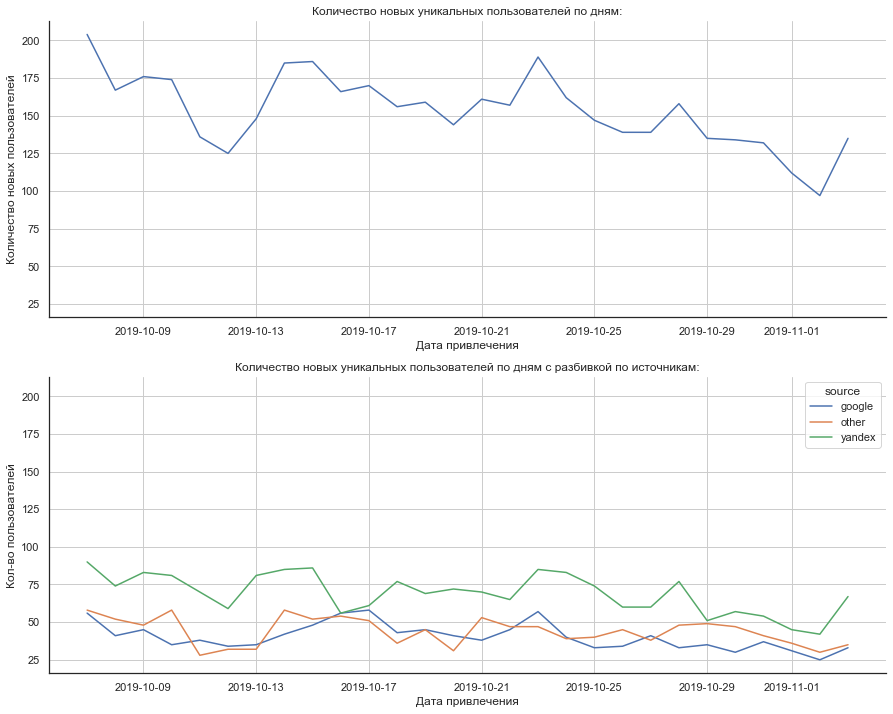

In [109]:
# Кол-во новых пользователей по дням:
coms = (profiles_raw.groupby('dt')['user_id']
        .count()
        .reset_index()
        .rename(columns={'user_id': 'user_cnt'})
       )

# Кол-во новых пользователей по дням и источникам:
coms_srs = (profiles_raw.groupby(['dt', 'source'])['user_id']
            .count()
            .reset_index()
            .rename(columns={'user_id': 'user_cnt'})
           )

# Графики:
sns.set(style='white')
plt.figure(figsize=(15, 12))

ax1 = plt.subplot(2, 1, 1)
sns.lineplot(data=coms, x='dt', y='user_cnt', ax=ax1)
sns.despine()
plt.title('Количество новых уникальных пользователей по дням:')
plt.ylabel('Количество новых пользователей')
plt.xlabel('Дата привлечения')
plt.grid()

ax2 = plt.subplot(2, 1, 2, sharey=ax1)
sns.lineplot(data=coms_srs, x='dt', y='user_cnt', hue='source', ax=ax2)
sns.despine()
plt.title('Количество новых уникальных пользователей по дням с разбивкой по источникам:')
plt.ylabel('Кол-во пользователей')
plt.xlabel('Дата привлечения')
plt.grid()
plt.show()

**Выводы:**

Как правило начало работы пользователей с приложением начинается с показа рекомендованных объявлений или поиска, а ещё довольно часто с просмотра карты или фотографий

По графикам просматривается небольшой спад кол-ва новых пользователей за месяц.

### 2.2 Выделение сессий пользователей

Выделение сессий по следующей логике - если интервал между 2мя последующими событиями для пользователя превышает некоторое значение, то открывается новая сессия.

In [110]:
# Функция присвоения номера сессии по интервалу:
def session(df, interval):
    """функция для индексации сессий по интервалу между событиями
    
    на вход принимает:
    - датафрейм 
    - предельное значение интервала между событиями, относящимися к одной сессии
    """
    pass
    counter = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta(interval)).cumsum()
    result = df.groupby(['user_id', counter]).ngroup() + 1
    return result

В качестве интервала должно быть реалистичное значение, которое пользователь может потратить на переход между действиями. Оно должно учитывать, что пользователь мог на что-то отвлечься в процессе сессии, но при этом не быть слишком большим, что бы не связать в одну разные реальные сессии.

Можно рассмотреть значения в диапазоне 5 - 30 минут с шагом в 5 мин и сравнить их по качеству деления, в качестве индикатора возьмем получившееся кол-во сессий с 1 действием (в идеале минимализировать такие сессии), когда кол-во таких сессий перестанет существенно уменьшаться при увеличении интервала, то этот интервал можно будет принять за компромисное значение.   

Сравнение интервалов:

In [111]:
mob_dt = mob_dt.sort_values(['user_id', 'event_time'])

for i in range(5, 31, 5):
    i = str(i)+' min'
    mob_dt['ses_id'] = session(mob_dt, interval = i)
    print('Интервал:', i ,
          ' Всего сессий:', mob_dt['ses_id'].nunique(),
          ' Сессий с 1м событием:', (mob_dt
                                     .groupby('ses_id', as_index=False)['event_name']
                                     .count()
                                     .query('event_name == 1')['event_name']
                                     .count()
                                    ) 
         )

Интервал: 5 min  Всего сессий: 16366  Сессий с 1м событием: 5221
Интервал: 10 min  Всего сессий: 12691  Сессий с 1м событием: 3175
Интервал: 15 min  Всего сессий: 11537  Сессий с 1м событием: 2618
Интервал: 20 min  Всего сессий: 10975  Сессий с 1м событием: 2328
Интервал: 25 min  Всего сессий: 10633  Сессий с 1м событием: 2179
Интервал: 30 min  Всего сессий: 10368  Сессий с 1м событием: 2088


Видно, что при дальнейшем увеличении интервала после 15 мин кол-во сессей изменяется незначительно, возьмем этот интервал для дальнейшего использования

Выделение номеров сессий:

In [112]:
# Сортировка данных по пользователям в хронологическом порядке
mob_dt = mob_dt.sort_values(['user_id', 'event_time'])

# Выделение номеров сессий
mob_dt['ses_id'] = session(mob_dt, interval = '15min')

print('Количество сессий:', mob_dt['ses_id'].nunique())

Количество сессий: 11537


Датафрейм с данными о сессиях: id пользователя, id сессии, время первого и последнего событий, кол-во действий за сессию, длительность сессии:

In [113]:
# Датафрейм сессий:
sessions = (mob_dt.groupby(['user_id', 'ses_id'])
            .agg(ses_start=('event_time', 'min'), # время первого события
                 ses_end=('event_time', 'max'), # время последнего события
                 event_count=('event_name', 'count') # кол-во событий за сессию
                )
            .reset_index()
           )

# длительность сессии:
sessions['ses_duration'] = sessions['ses_end'] - sessions['ses_start'] 
sessions['ses_duration_sec'] = sessions['ses_duration'].astype('timedelta64[s]') # в секундах
sessions['min_per_ev'] = (sessions['ses_duration_sec'] / 60) / sessions['event_count'] # время на одно действие в минутах

# округление времени до секунд:
for column in sessions.select_dtypes(include=['datetime', 'timedelta']).columns:
    sessions[column] = sessions[column].dt.round('S')

Просмотр данных:

In [114]:
sessions.sort_values('ses_duration')

,user_id,ses_id,ses_start,ses_end,event_count,ses_duration,ses_duration_sec,min_per_ev
5768,82e10f7e-7283-4d4f-93a1-3710b00475be,5769,2019-10-09 21:19:44,2019-10-09 21:19:44,1,00:00:00,0.000,0.000
6612,967a707b-2b3c-48bd-b5cb-5109bd90781e,6613,2019-10-22 15:58:17,2019-10-22 15:58:17,1,00:00:00,0.000,0.000
2230,2d194888-2d8d-453c-b1d8-12bae0741788,2231,2019-10-09 20:36:24,2019-10-09 20:36:24,1,00:00:00,0.000,0.000
6603,96505500-e5e8-4e58-b970-80bc97a33ee7,6604,2019-10-18 21:33:58,2019-10-18 21:33:58,1,00:00:00,0.000,0.000
6600,96505500-e5e8-4e58-b970-80bc97a33ee7,6601,2019-10-14 21:09:01,2019-10-14 21:09:01,1,00:00:00,0.000,0.000
...,...,...,...,...,...,...,...,...
7632,abdcbe3c-221b-4f59-afd9-bf9ca78f7e4c,7633,2019-10-29 14:37:20,2019-10-29 17:19:48,113,02:42:28,"9,748.000",1.438
10455,e549f8ef-653b-4c5c-a6bd-8970e6bd860b,10456,2019-10-22 19:57:57,2019-10-22 22:42:47,104,02:44:50,"9,889.000",1.585
10044,dd61b125-4b5f-4312-82dc-dcc431980265,10045,2019-11-02 19:46:32,2019-11-02 22:46:36,52,03:00:04,"10,803.000",3.463
7597,abc47bf2-6ed0-432b-bc23-bd1adf4f29bc,7598,2019-10-27 01:24:21,2019-10-27 04:36:45,85,03:12:23,"11,543.000",2.263


Кол-во сессий с нулевой продолжительностью:

In [115]:
sessions.query('ses_duration_sec == 0')['ses_id'].nunique()

2706

Просмотрим кол-во действий, совершённых пользователями с нулевой продолжительностью сессии:

In [116]:
a = sessions.query('ses_duration_sec == 0')['ses_id'].unique()
mob_dt.query('ses_id in @a')['event_name'].value_counts()

tips_show        1189
photos_show       740
search            436
contacts_show     183
map               137
advert_open        59
favorites_add      46
tips_click         17
contacts_call       1
Name: event_name, dtype: int64

Всего действий:

In [117]:
mob_dt['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

Скорее всего большая часть подобных событий не связаны с работой с приложением или входы, что бы например уточнить какие-то данные посмотренные раньше.
Имеет смысл исключить данных пользователей из дальнейшего анализа

In [118]:
sessions = sessions.query('ses_duration_sec != 0')

In [119]:
sessions.describe()

,ses_id,event_count,ses_duration,ses_duration_sec,min_per_ev
count,"8,831.000","8,831.000",8831,"8,831.000","8,831.000"
mean,"5,798.332",8.084,0 days 00:12:20.016419,739.525,1.550
std,"3,336.170",9.192,0 days 00:15:04.485605,904.483,1.258
min,1.000,2.000,0 days 00:00:01,1.000,0.003
25%,"2,910.000",3.000,0 days 00:02:42,161.500,0.641
50%,"5,849.000",5.000,0 days 00:07:29,449.000,1.253
75%,"8,729.500",9.000,0 days 00:16:15.500000,975.000,2.133
max,"11,537.000",139.000,0 days 03:53:39,"14,018.000",8.011


График распределения длительности сессий:

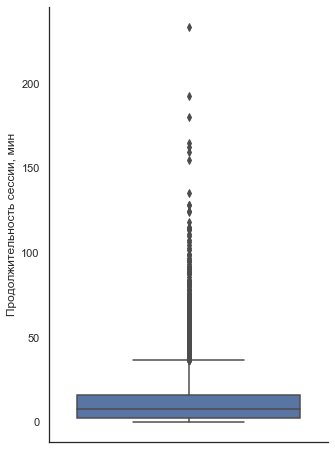

In [120]:
plt.figure(figsize=(5,8))

sns.boxplot(y=(sessions['ses_duration_sec'] / 60))
sns.despine()
plt.ylabel('Продолжительность сессии, мин')
plt.show()

In [121]:
a = pd.Timedelta('45min')
print('Кол-во аномальных сессий, длинее 45 минут:' , len(sessions[sessions['ses_duration'] > a]))

Кол-во аномальных сессий, длинее 45 минут: 328


**Выводы:**

Средняя продолжительность сессии 12 минут 20 сек, медианная 7 мин 29 сек

Порядка 3,7% сессий находятся за пределами 3х стандартных отклонений по длительности.

В среднем пользователи тратят 1,5 минуты на одно событие.

**Добавление в профили средней частоты событий и среднего времени сессий:**

In [122]:
# inner merge сразу отфильтрует пользователей с нулевой продолжительностью сессий:
profiles = (profiles_raw
            .merge(sessions.groupby('user_id')['event_count', 'ses_duration_sec', 'min_per_ev']
                   .mean()
                   .reset_index(), 
                   on='user_id'
                  )
            .rename(columns = {'event_count': 'avg_ev_cnt', 
                               'ses_duration_sec': 'avg_duration_sec',
                               'min_per_ev': 'avg_min_per_ev'
                              })
           )

### 2.3 Расчёт Retention Rate

#### Функция расчёта Retention Rate по когортам:

In [123]:
def get_retention(
    profiles, 
    sessions, 
    observ_date, 
    hor_days, 
    dimensions=[], 
    ignor_hor=False):
    
    """функция для расчёта Retention Rate
    
    на вход принимает:
    - датафрейм с данными пользователями
    - датафрейм с данными о сессиях
    - момент анализа
    - горизонт анализа
    - признаки когорт
    - установку игнорировать ли горизонт (по умолчанию не игнорировать)
    """
    pass

# Установка горизонта анализа:
    last_date = observ_date
    if not ignor_hor:
        last_date = observ_date - timedelta(days= hor_days - 1)
    
    retention_df = profiles.query('dt <= @last_date')
    
# df для расчёта Retention Rate:
    retention_df = (retention_df
                    .merge(sessions[['user_id', 'ses_start']], 
                           on='user_id', 
                           how='left')
                   )
    
# Вычисление лайфтайма каждой сессии:
    retention_df['lifetime'] = (retention_df['ses_start'] - retention_df['first_ses']).dt.days

# группировка по cohort, если в dimensions ничего нет:
    if len(dimensions) == 0:
        retention_df['cohort'] = 'all users'
        dimensions = dimensions + ['cohort']
        
# Таблица удержания:
    ret_grouped = retention_df.pivot_table(
        index=dimensions, 
        columns='lifetime', 
        values='user_id', 
        aggfunc='nunique'
    )
    
# Размеры когорт:
    ch_size = (retention_df
               .groupby(dimensions)
               .agg({'user_id': 'nunique'})
               .rename(columns={'user_id': 'ch_size'})
              )
    
# объединение размеров когорт и таблицы удержания
    ret_grouped = ch_size.merge(ret_grouped, on=dimensions).fillna(0)
    
#  расчёт Retention Rate
    ret_grouped = ret_grouped.div(ret_grouped['ch_size'], axis=0)
    
# выделение в df размера когорт и горизонта анализа:    
    ret_grouped = ret_grouped[['ch_size'] + list(range(hor_days))]
    ret_grouped['ch_size'] = ch_size
    
    return retention_df, ret_grouped

Функция отрисовки графиков удержания:

In [124]:
def retention_plot(retention):
    """Отображает графики крифых удержания и тепловую карту по когортам
    
    принимает на вход таблицу удержания
    """
    pass
# Кривые удержания:
    plt.figure(figsize=(15,5))
    
    sns.lineplot(data=retention.drop(['ch_size', 0], axis=1).T)
    sns.despine()
    plt.title('Кривые удержания')
    plt.xlabel('Время жизни')
    plt.ylabel('Уровень удержания')
    plt.grid()
    plt.show()
    
#   Тепловая карта:  
    plt.figure(figsize=(15, 5))
    sns.heatmap(retention.drop(columns=['ch_size', 0]), annot=True, fmt='.2%')
    plt.title('Тепловая карта удержания')
    plt.xlabel('Время жизни')
    plt.show()

#### Применение функции

**Графики по всем пользователям:**

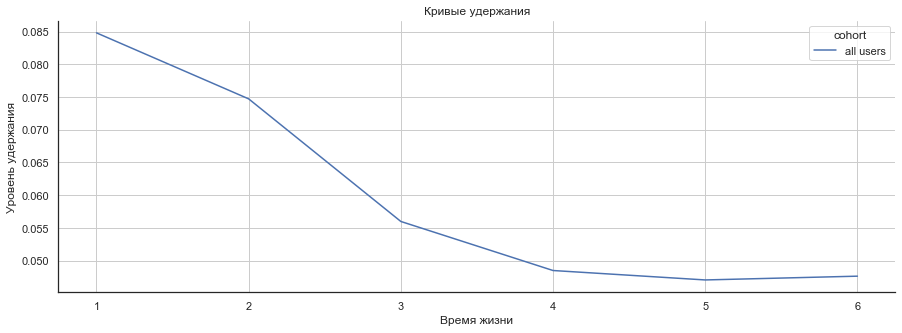

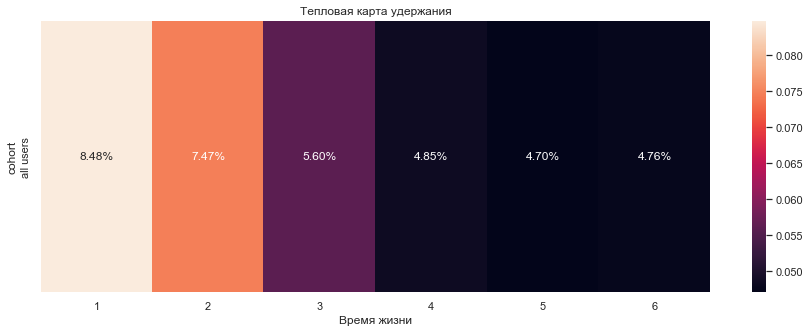

In [125]:
ret_raw, retention = get_retention(
    profiles, 
    sessions, 
    mob_dt['event_time'].max(), 
    7,
    dimensions=[]
)

retention_plot(retention)

**Графики удержания по источникам привлечения:**

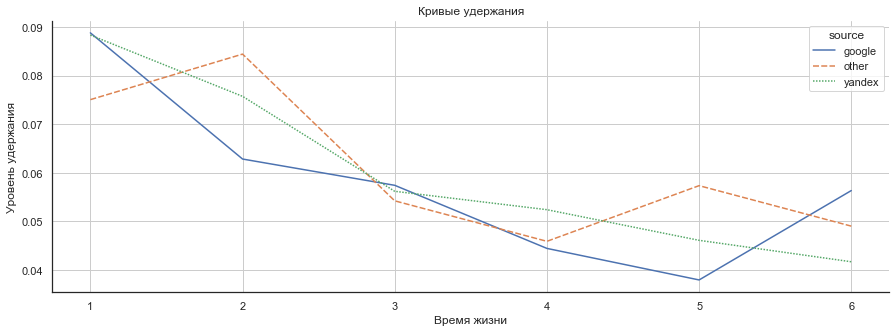

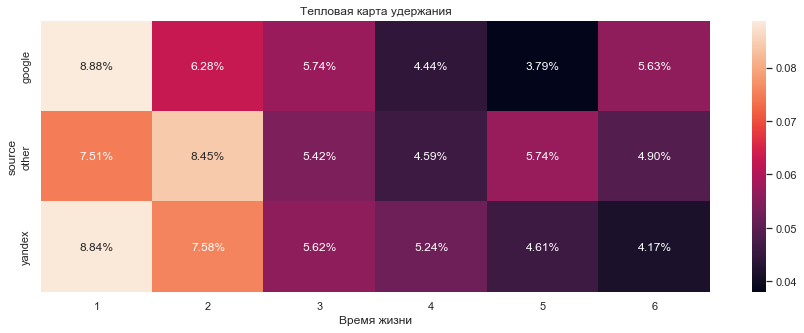

In [126]:
ret_raw, retention = get_retention(
    profiles, 
    sessions, 
    mob_dt['event_time'].max(), 
    7,
    dimensions=['source']
)

retention_plot(retention)

**Графики удержания по неделе привлечения:**

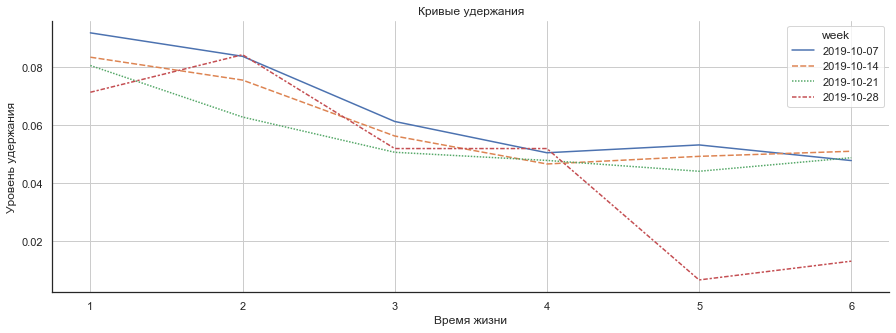

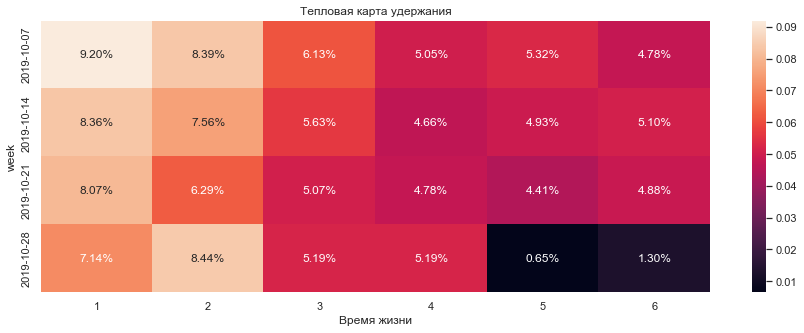

In [127]:
ret_raw, retention = get_retention(
    profiles, 
    sessions, 
    mob_dt['event_time'].max(), 
    7,
    dimensions=['week']
)

retention_plot(retention)

**Выводы:**

- Общий `Retention Rate` на 7й день - 4,76%;
- Самая плохая динамика удержания на 7й день у пользователей пришедших из `yandex`, самая хорошая у пользователей из `google`
- Время прихода пользователей в октябре не влияет на удержание, у последней недели низкие показатели, но туда попали данные только за один день, а не всю неделю.

Добавим в профили пользователей параметр, указывающий на то вернулся ли пользователь в приложение через на 4й день и позже после первого посещения (lifetime > 2)

#### Добавление параметров в профиль:

In [128]:
# Найдём лайфтаймы для всех пользователей, игнорирую горизонт анализа:
ret_raw, retention = get_retention(
    profiles, 
    sessions, 
    mob_dt['event_time'].max(), 
    4,
    dimensions=[],
    ignor_hor=True
)

# Признак возврата пользователя
ret_raw_grp = ret_raw.groupby('user_id')['lifetime'].max().reset_index()
ret_raw_grp['return'] = ret_raw_grp['lifetime'].apply(lambda x: 1 if x > 2 else 0)

# Добавление признака в профили
profiles = profiles.merge(ret_raw_grp[['user_id', 'return']], on='user_id')

### 2.4 Конверсия:

**Добавление в профили пользователей, кол-ва целевых действий и бинарного признака совершения целевого действия:**

In [129]:
profiles = profiles.merge(mob_dt
                          .query('event_name == "contacts_show"')
                          .groupby('user_id')
                          .agg({'event_name': 'count'}), 
                          on='user_id', 
                          how='left'
                         ).fillna(0).rename(columns={'event_name': 'target_ev_amt'})

profiles['conversion'] =  profiles['target_ev_amt'].apply(lambda x: 1 if x > 0 else 0)

Выделим кол-во каждого события для пользователя, как признаки:

In [130]:
corr = mob_dt.pivot_table(
    index='user_id', 
    columns='event_name',
    values='ses_id', 
    aggfunc='sum').fillna(0)

Просмотр корреляции между событиями, и поиск взаимосвязи событий с целевым:

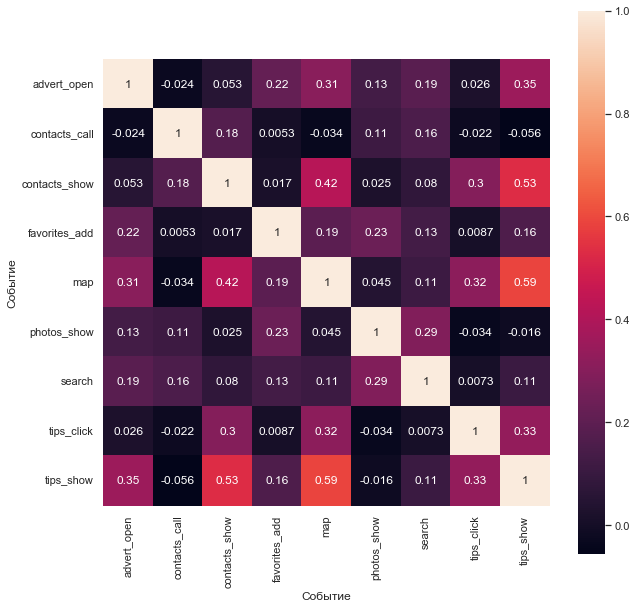

In [131]:
plt.figure(figsize=(10,10))
sns.heatmap(corr.corr(), square=True, annot=True)
plt.xlabel('Событие')
plt.ylabel('Событие')
plt.show()

**Вывод:**

Целевое событие (`contacts_show`) наиболее сильно коррелирует с просмотром карты, показом и переходом по рекомендациям

Конверсия в события:

In [132]:
def get_conversion(df, ch_dims=[], filtr_dims=[], filtr=False):
    
    """Функция расчёта таблицы конверсии с фильтрацией попервому событию
    
    на вход принимает:
    - датасет с событиями
    - 
    - события по которым фильтровать
    - вкл/выкл фильтра (по умолчанию выкл)
    
    """
    pass
    
#   Фильтр
    if filtr:
        
#   Сессии, где первое действие - значение фильтра:
        check = (
            df.sort_values(['ses_id', 'event_time'])
            .groupby('ses_id')['event_name']
            .first()
            .reset_index()
            .query('event_name in @filtr_dims')['ses_id']
        )
    
#   Срез данных по отфильтрованным сессиям:    
        df = df.query('ses_id in @check')
    
#   Подсчет количества событий и пользователей:        
    result = (df
              .groupby(ch_dims + ['event_name'], as_index=False)
              .agg({'user_id':['count', 'nunique']})
             )
    
    # группировка
    result.columns = ch_dims + ['event_name', 'event_count', 'user_count'] # переименование столбцов
    result = result.sort_values('user_count', ascending=False).reset_index(drop=True) #  сортировка
    
#   Добавление общего кол-ва пользователей по когортам:   

    df_cnt = df.copy()
    
    if len(ch_dims) == 0:
        df_cnt['clusters'] = 'all_users'
        result['clusters'] = 'all_users'
        ch_dims = ch_dims + ['clusters']
        
    result = result.merge(
        df_cnt.groupby(ch_dims)['user_id'].nunique(), 
        on='clusters'
    ).rename(columns={'user_id': 'user_total_count'})
    
#   Процент конверсии в событие от уникальных пользователей    
    result['user_part'] = (
        (result['user_count'] / result['user_total_count'])
        .map(lambda x: '{:.2%}'.format(x))
                        )
    result = result.drop('user_total_count', axis=1)
        
    return result

Общая конверсия:

In [133]:
conv = get_conversion(mob_dt)

conv

,event_name,event_count,user_count,clusters,user_part
0,tips_show,40055,2801,all_users,65.25%
1,search,6784,1666,all_users,38.81%
2,map,3881,1456,all_users,33.92%
3,photos_show,10012,1095,all_users,25.51%
4,contacts_show,4529,981,all_users,22.85%
5,advert_open,6164,751,all_users,17.49%
6,favorites_add,1417,351,all_users,8.18%
7,tips_click,814,322,all_users,7.50%
8,contacts_call,541,213,all_users,4.96%


**Выводы:**

- целевое действие совершают 22,85% уникальных пользователей;
- всего 7,5% уникальных пользователей переходят по рекомендованным объявлениям;
- пользователи смотрят фотографии из объявлений, контакты и карту чаще, чем открывают карточки объявлений

**Конверсия в события для сессий начинающихся с `tips_show`:**

In [134]:
conv_tips = get_conversion(
    mob_dt,
    filtr_dims=['tips_show'],
    filtr=True
    )

conv_tips

,event_name,event_count,user_count,clusters,user_part
0,tips_show,24965,1834,all_users,100.00%
1,map,754,354,all_users,19.30%
2,contacts_show,1347,304,all_users,16.58%
3,tips_click,477,210,all_users,11.45%
4,advert_open,840,147,all_users,8.02%
5,search,206,90,all_users,4.91%
6,favorites_add,367,61,all_users,3.33%


**Конверсия в события для сессий начинающихся с `search`:**

In [135]:
conv_search = get_conversion(
    mob_dt, 
    filtr_dims=['search'],
    filtr=True
    )

conv_search

,event_name,event_count,user_count,clusters,user_part
0,search,5823,1413,all_users,100.00%
1,tips_show,5038,594,all_users,42.04%
2,photos_show,2555,460,all_users,32.55%
3,map,535,250,all_users,17.69%
4,contacts_show,580,198,all_users,14.01%
5,advert_open,1055,145,all_users,10.26%
6,favorites_add,412,115,all_users,8.14%
7,contacts_call,131,62,all_users,4.39%
8,tips_click,33,28,all_users,1.98%


Рассмотрим воронки, которые начинаются с событий `tips_show` и `search`, как самые частые события.

`tips_show -> map -> tips_click -> contacts_show`

`search -> photo_show -> map -> contacts_show`

Событийные воронки:

In [136]:
for df, name in zip([conv_tips.reindex([0, 1, 3, 2]), conv_search.drop(1, axis=0)], 
                    ['Воронка через рекомендации', 'Воронка через поиск']):
    print('\n', name)
    fig = go.Figure(
        go.Funnel(     
            y = df[0:4]['event_name'],
            x = df[0:4]['user_count'],
            textinfo = "value+percent initial"            
        )
    )
    
    fig.show() 


 Воронка через рекомендации



 Воронка через поиск


- Доля пользователей доходящая до просмотра контактов:
    - 17% от всех пользователей, начавших сессию с рекомендованных объявлений
    - 14% от всех пользователей начавших сессию с поиска
    
Если пользователи начинают сессию с поиска, то они скорее всего последовательно идут от изучения объявлений к просмотру контактов. В тоже время при начале с показа рекомендаций, рекомендации как правило игнорируются и далее пользователь переходит на карту или сразу в контакты (можно предположить, что это повторные входы и пользователи уже знают конкретные объявления, которые им нужны)

### 2.5 Изучение профиля пользователей

Избавимся от ноябрьских пользователей, т.к. у них слишком короткий lifetime и они не показательны:

In [137]:
profiles = profiles.query('dt <= "2019-10-31"')

In [138]:
profiles.head(2)

,user_id,first_event,first_ses,dt,week,source,avg_ev_cnt,avg_duration_sec,avg_min_per_ev,return,target_ev_amt,conversion
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,tips_show,2019-10-07 13:39:46,2019-10-07,2019-10-07,other,8.750,689.750,1.466,1,0.000,0
1,00157779-810c-4498-9e05-a1e9e3cedf93,search,2019-10-19 21:34:34,2019-10-19,2019-10-14,yandex,9.857,"1,095.286",1.839,1,11.000,1


Выделение признаков, удаление лишних граф, преобразование категориальных признаков:
- убираем все временные параметры - за них отвечает параметр `return`;
- убираем `source` т.к. при его наличии алгоритм в итоге просто кластеризует по источнику привлечения

In [139]:
feauter_df = profiles.drop(['user_id', 'first_event', 'first_ses', 'dt', 'week', 'source'], axis=1)

In [140]:
feauter_df.head()

,avg_ev_cnt,avg_duration_sec,avg_min_per_ev,return,target_ev_amt,conversion
0,8.750,689.750,1.466,1,0.000,0
1,9.857,"1,095.286",1.839,1,11.000,1
3,3.556,319.889,2.033,1,0.000,0
4,3.500,279.500,0.939,0,3.000,1
5,5.500,211.000,0.624,0,0.000,0


Графики распределения признаков для тех, кто совершил и не совершил целевое действие:


 Графики распределения признака: avg_ev_cnt


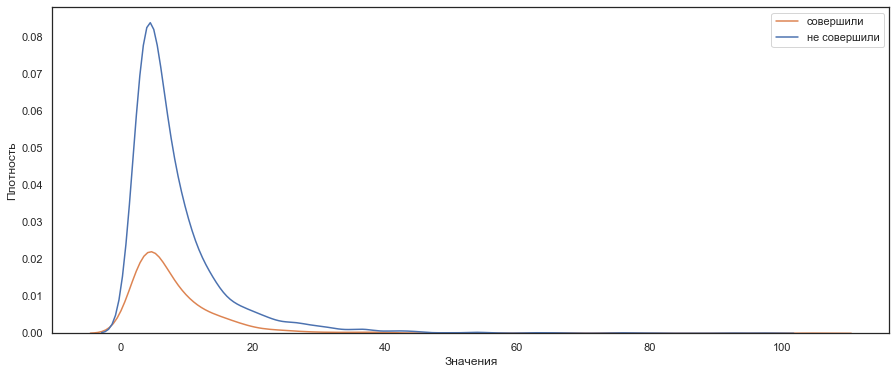


 Графики распределения признака: avg_duration_sec


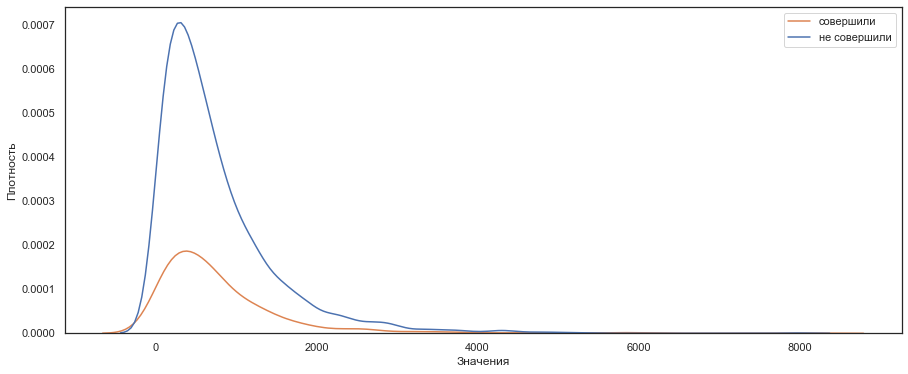


 Графики распределения признака: avg_min_per_ev


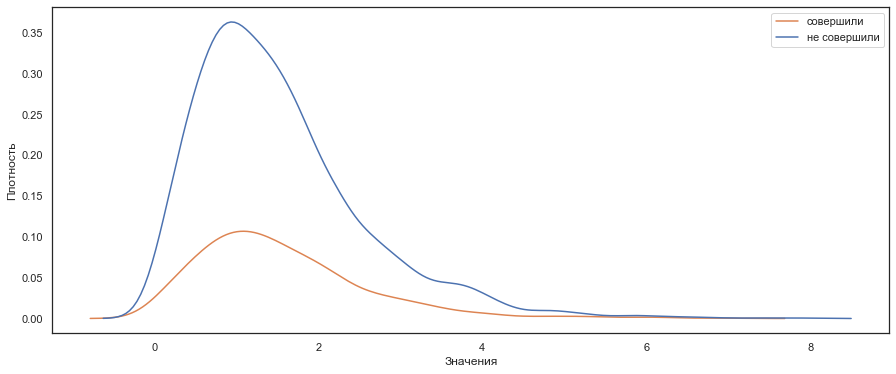


 Графики распределения признака: return


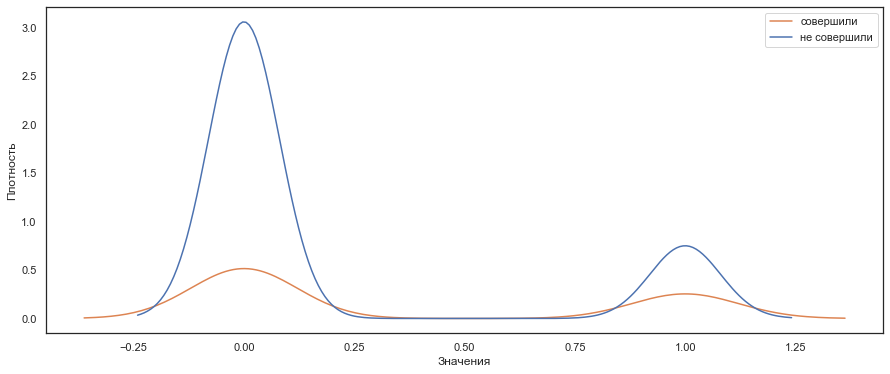


 Графики распределения признака: target_ev_amt


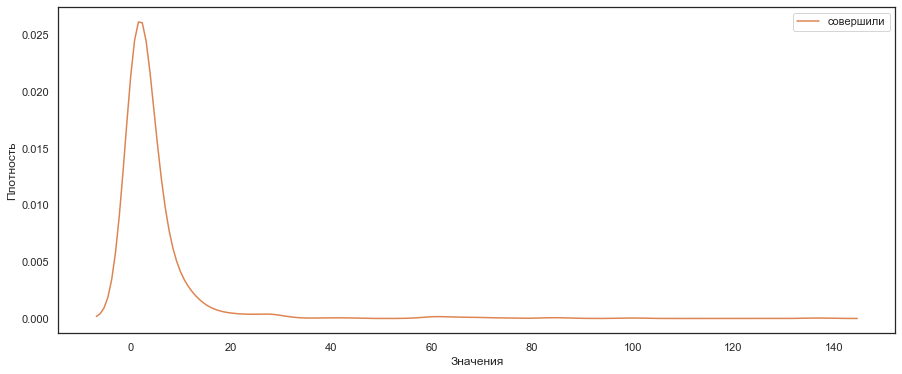

In [141]:
for name in feauter_df.drop('conversion', axis=1).columns:
    print('\n Графики распределения признака:', name)
    plt.figure(figsize=(15,6))
    sns.kdeplot(data=feauter_df, x=name, hue='conversion')
    plt.ylabel('Плотность')
    plt.xlabel('Значения')
    plt.legend(['совершили', 'не совершили'])
    plt.show()

**Вывод:**
Распределение признаков для совершивших и не совершивших целевое действие очень похожи.

Матрица взаимной корреляции признаков:

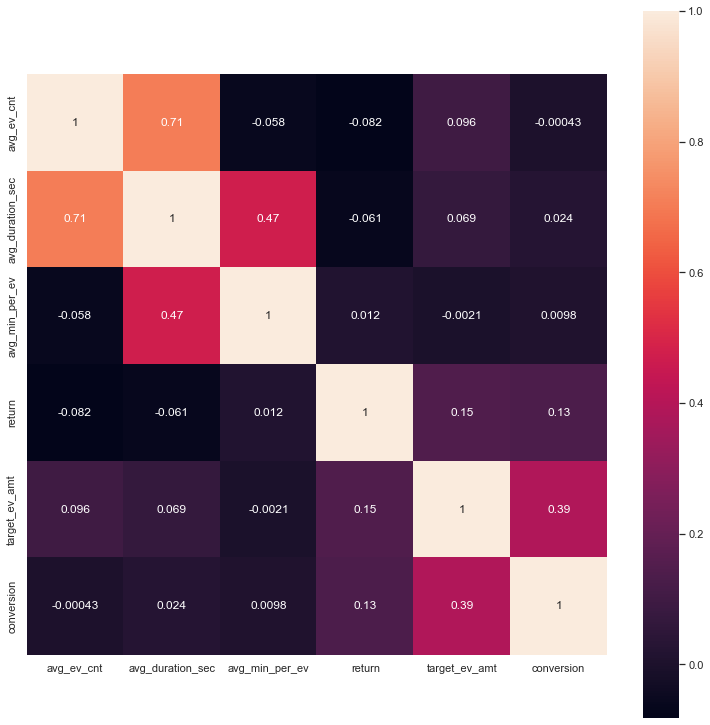

In [142]:
plt.figure(figsize=(13,13))
sns.heatmap(feauter_df.corr(), square=True, annot=True)
plt.show()

В профиле есть достаточно сильно коррелирующие признаки, но не критично для удаления

## 3. Сегментирование пользователей

Стандартизация данных для кластеризации:

In [143]:
scaler = StandardScaler()
X_st = scaler.fit_transform(feauter_df)

Матрица расстояний признаков и дендрограмма для определения ко-ва кластеров:

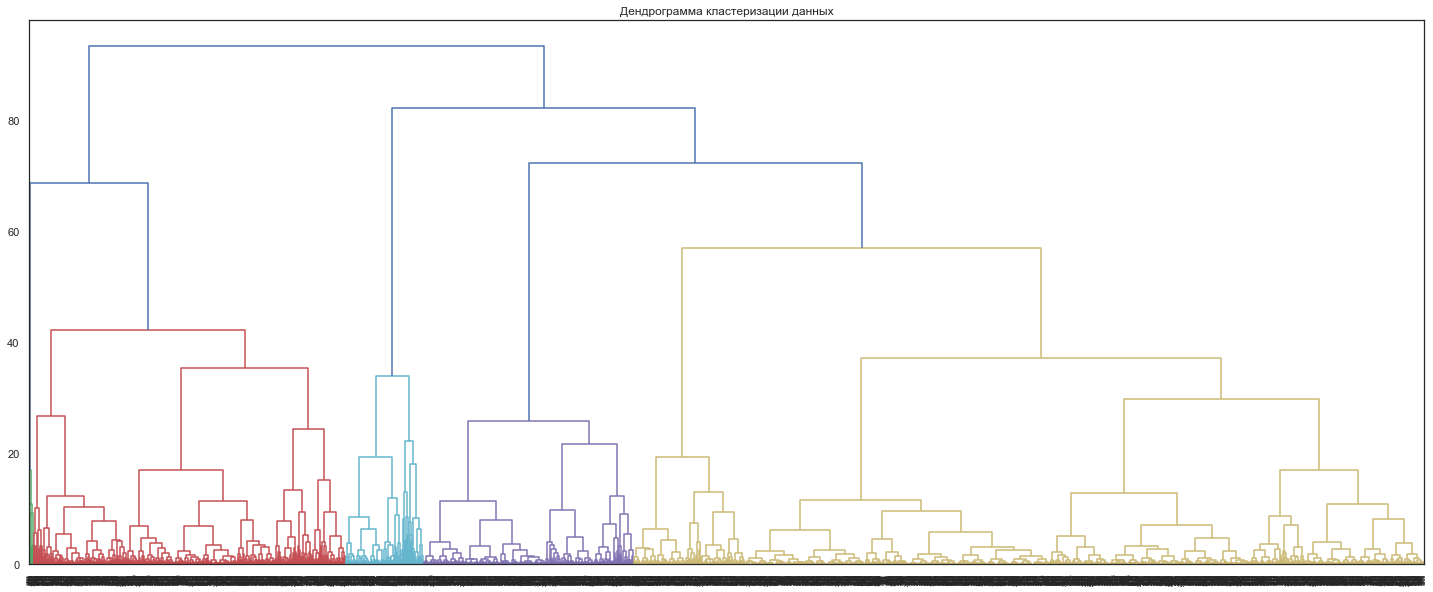

In [144]:
plt.figure(figsize=(25, 10))
linked = linkage(X_st, 'ward')
dendrogram(linked)
plt.title('Дендрограмма кластеризации данных')
plt.show()

На основании дендограммы можно выделить 3-5 кластера пользователей.

Проведем кластеризацию пользователей на 3 кластера:

In [145]:
km = KMeans(n_clusters=3, random_state=0)
labels = km.fit_predict(X_st)

# добавим кластеры в профили пользователей и параметры
feauter_df['clusters'] = labels
profiles['clusters'] = labels

Вернем метрики источников:

In [146]:
feauter_df['source'] = profiles['source']
feauter_df = pd.get_dummies(feauter_df) # представим источники числовыми параметрами
feauter_df.head()

,avg_ev_cnt,avg_duration_sec,avg_min_per_ev,return,target_ev_amt,conversion,clusters,source_google,source_other,source_yandex
0,8.750,689.750,1.466,1,0.000,0,0,0,1,0
1,9.857,"1,095.286",1.839,1,11.000,1,1,0,0,1
3,3.556,319.889,2.033,1,0.000,0,0,1,0,0
4,3.500,279.500,0.939,0,3.000,1,1,0,0,1
5,5.500,211.000,0.624,0,0.000,0,0,0,0,1


Средние показатели метрик по когортам:

In [147]:
feauter_df.groupby('clusters').mean().sort_values('clusters')

,avg_ev_cnt,avg_duration_sec,avg_min_per_ev,return,target_ev_amt,conversion,source_google,source_other,source_yandex
clusters,,,,,,,,,
0,6.670,568.622,1.476,0.207,0.000,0.000,0.256,0.301,0.442
1,7.076,630.014,1.507,0.340,4.656,1.000,0.287,0.235,0.478
2,26.157,"2,520.494",1.969,0.110,1.125,0.157,0.279,0.259,0.462


Медианные показатели метрик по когортам:

In [148]:
(feauter_df
 .groupby('clusters')['avg_ev_cnt', 'avg_duration_sec', 'avg_min_per_ev']
 .median()
 .sort_values('clusters')
)

,avg_ev_cnt,avg_duration_sec,avg_min_per_ev
clusters,,,
0,5.500,474.750,1.273
1,5.706,531.000,1.303
2,23.000,"2,297.500",1.666


Размеры когорт:

In [149]:
feauter_df.groupby('clusters')['return'].count()

clusters
0    2672
1     843
2     344
Name: return, dtype: int64

**Выводы:**

Модель ML выделила 3 кластера пользователей:

1. Самая многочисленная (2672 пользователя) - с нулевой конверсией в целевое действие, у которых самые низкие показатели по кол-ву действий за сессию (медиана - 5,5) и продолжительности сессий (около 8 мин) (хотя они сопоставимы со значениями 2 кластера). Они не совершают целевого действия, но возвращаются в приложение в 20,7% случаев. 
2. 843 пользователя - все группе совершили целевое действие, медианное время сессии порядка 9 мин, возвращаются в приложение в 34% случаев
3. Самая маленькая (344 пользователя) - целевое действие совершили порядка 15,7% пользователей группы, длинные сессии (медиана ~38 мин), время на одно событие на ~27-28% больше чем у других групп, а уровень возврата чуть больше 11%

### Итоговый анализ после группировки:

**Retantion Rate по когортам:**

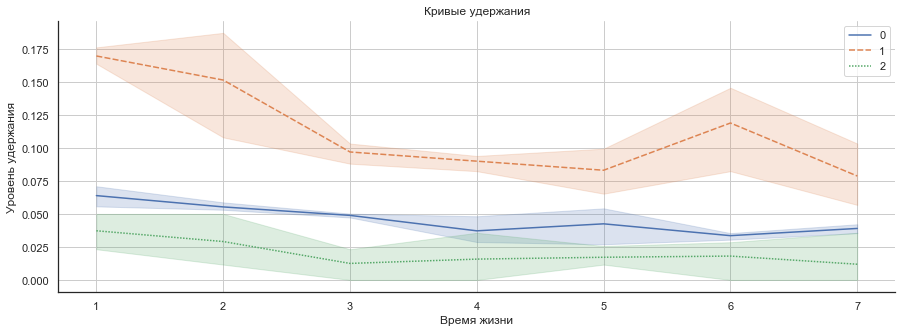

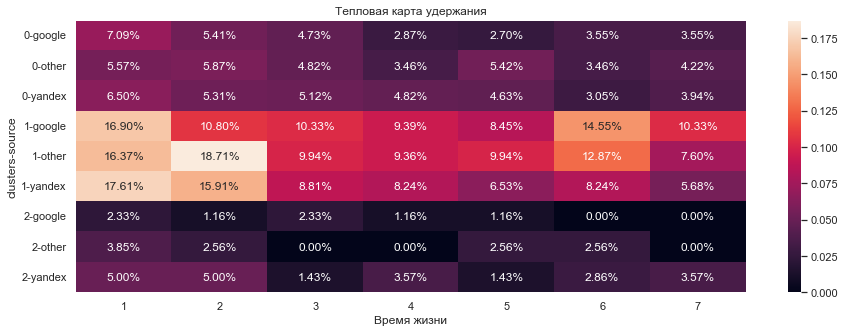

In [150]:
ret_raw, retention = get_retention(
    profiles, 
    sessions, 
    mob_dt['event_time'].max(), 
    8,
    dimensions=['clusters', 'source']
)

retention_plot(retention)

**Выводы:**

- 1я группа люди, которые изредка изучают асортимент приложения, но не смотрят контакты продавцов
- у 2й группы самый лучший показатель удержания, можно предположить, что это постоянные пользователи.
- 3я группа почти не остается в приложении, скорее всего сюда попали люди, которые в первый раз пришли, долго искали, что им нужно и больше не возвращались.

Можно отметить, что лучшие показатели удержания у пользователей, пришедших из google, а хуже всего удерживаются пользователи из yandex

**Конверсия:**

Посчитаем конверсию в события от всех пользователей по получившимся кластерам:

In [151]:
mob_dt.head()

,event_time,event_name,user_id,event_date,event_week,ses_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07,1
806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07,1
809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07,1
820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07,1
830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07,1


In [152]:
# DF для конверсии с пользователями, вошедшими в кластеризацию
conversion_df = mob_dt.merge(profiles[['user_id', 'clusters']], on='user_id')

# Функция конверсии:
conv_result = get_conversion(conversion_df,      
                             ch_dims=['clusters'])

Результаты:

In [153]:
conv_result.sort_values(['clusters', 'user_count'], ascending=False)

,clusters,event_name,event_count,user_count,user_part
16,2,tips_show,9254,303,88.08%
17,2,map,717,188,54.65%
18,2,search,421,120,34.88%
19,2,advert_open,1596,91,26.45%
20,2,contacts_show,387,54,15.70%
21,2,tips_click,119,48,13.95%
22,2,photos_show,709,37,10.76%
23,2,favorites_add,335,34,9.88%
24,2,contacts_call,21,4,1.16%
7,1,contacts_show,3925,843,100.00%


**Различие во времени между событиями**

Популярность событий:

In [154]:
mob_dt['event_name'].value_counts()

tips_show        40055
photos_show      10012
search            6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

Наиболее популярные события: просмотр фото, поиск и открытие карточек объявлений (photos_show, search, advert_open). Показ рекомендаций не учитываем, т.к. скорее всего это автоматическое действие приложения.

Оценим время от начала сессии до популярных событий:

In [155]:
# Задаём DF с временем начала сессий и временами событий:
event_df = (sessions[['user_id', 'ses_id', 'ses_start']]
            .merge(mob_dt[['user_id', 'ses_id', 'event_time', 'event_name']], on=['user_id', 'ses_id'])
           ).merge(profiles[['user_id', 'clusters']], on='user_id', how='left')

# округление времени событий до секунд
event_df['event_time'] = event_df['event_time'].dt.round('s')

# Подсчёт времени между началом сессий и действиями
event_df['time_lag'] = event_df['event_time'] - event_df['ses_start']

# Удалим строки где "целевое" действие было первым действием
event_df = event_df[event_df['time_lag'] != pd.Timedelta(0)]

Подсчет интервалов:

In [156]:
# Подсчйт для каждой сессии минимальное времея от начала сессии до совершения события
event_df_gr = (event_df
               .groupby(['clusters','ses_id', 'event_name'], as_index=False)['time_lag']
               .min()
               .sort_values('time_lag')
              )
# Перевод в секунды
event_df_gr['time_lag'] = event_df_gr['time_lag'].astype('timedelta64[s]')

Посмотрим данные по распределению времени:

In [157]:
event_df_gr.describe()

,clusters,ses_id,time_lag
count,"13,726.000","13,726.000","13,726.000"
mean,0.556,"5,799.765",253.632
std,0.638,"3,350.803",430.396
min,0.000,1.000,1.000
25%,0.000,"2,907.000",40.000
50%,0.000,"5,835.000",110.000
75%,1.000,"8,749.000",291.000
max,2.000,"11,537.000","10,800.000"


Очень большой разброс значений, примем за выбросы, если пользователь не выполнил событие в течение одного дня (86400 сек) с момента первого использования приложения.

Изучим динамику по основным событиям:

In [158]:
for event in ['tips_show', 'photos_show', 'search', 'advert_open', 'contacts_show']: 
    print('\n Событие:', event)
    result = (event_df_gr
              .query("event_name == @event")
              .groupby(['clusters', 'event_name'], as_index=False)['time_lag']
              .agg(['mean', 'median']).reset_index()
             )
    display(result)


 Событие: tips_show


,clusters,event_name,mean,median
0,0.000,tips_show,152.081,95.000
1,1.000,tips_show,165.604,94.000
2,2.000,tips_show,186.011,107.000



 Событие: photos_show


,clusters,event_name,mean,median
0,0.000,photos_show,182.236,105.000
1,1.000,photos_show,218.402,121.000
2,2.000,photos_show,260.692,96.000



 Событие: search


,clusters,event_name,mean,median
0,0.000,search,155.267,33.000
1,1.000,search,268.482,78.000
2,2.000,search,432.024,28.000



 Событие: advert_open


,clusters,event_name,mean,median
0,0.000,advert_open,252.820,109.000
1,1.000,advert_open,357.754,146.500
2,2.000,advert_open,623.557,152.000



 Событие: contacts_show


,clusters,event_name,mean,median
0,1.000,contacts_show,363.614,203.000
1,2.000,contacts_show,"1,050.000",656.000


Посмотрим порядок действий в когортах по времени событий:

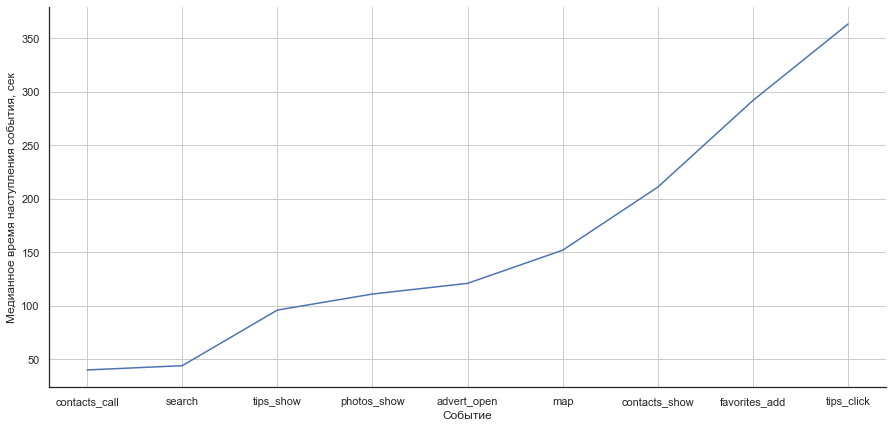

In [159]:
event_order = (event_df_gr.groupby(['event_name'], as_index=False)['time_lag']
            .agg(['mean', 'median']).reset_index().sort_values('median'))
        
plt.figure(figsize=(15,7))
sns.lineplot(data=event_order, x='event_name', y='median')
sns.despine()
plt.grid()
# plt.title('Группа {}'.format(cluster))
plt.xlabel('Событие')
plt.ylabel('Медианное время наступления события, сек')
plt.show()

По группам:

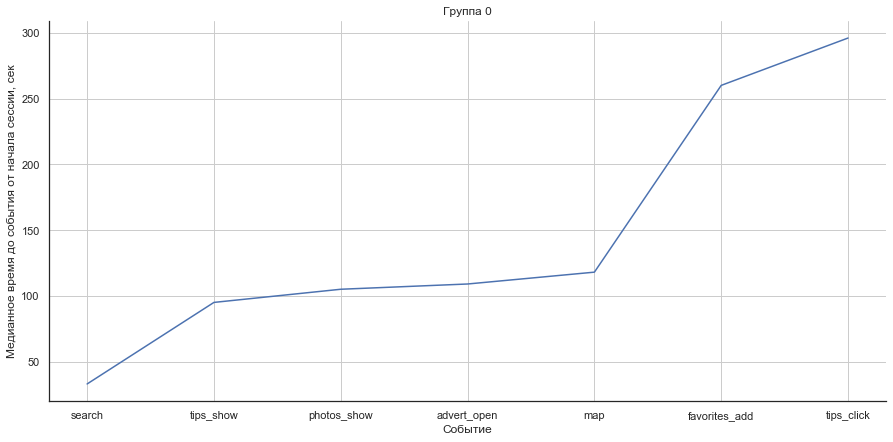

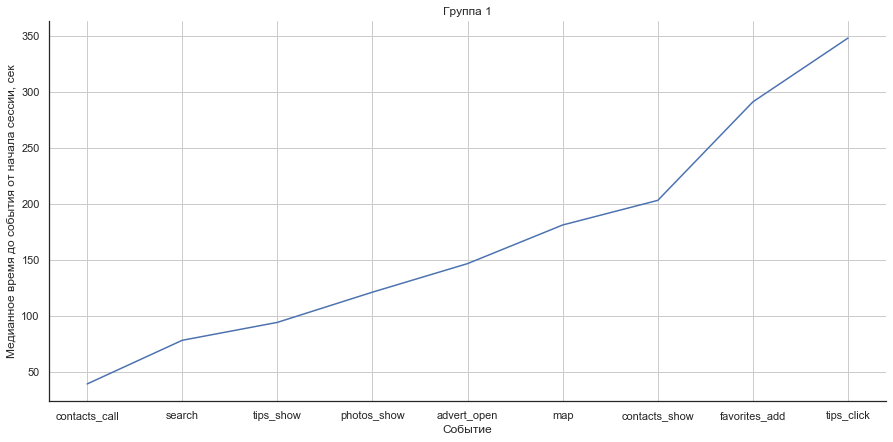

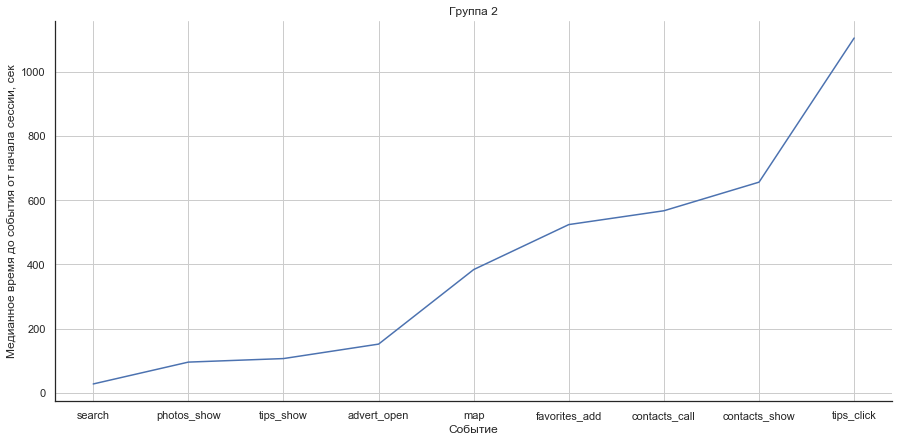

In [160]:
for cluster in [0, 1, 2]:
    event_order = (event_df_gr.query("clusters == @cluster")
            .groupby(['clusters', 'event_name'], as_index=False)['time_lag']
            .agg(['mean', 'median']).reset_index().sort_values('median'))
        
    plt.figure(figsize=(15,7))
    sns.lineplot(data=event_order, x='event_name', y='median')
    sns.despine()
    plt.grid()
    plt.title('Группа {}'.format(cluster))
    plt.xlabel('Событие')
    plt.ylabel('Медианное время до события от начала сессии, сек')
    plt.show()

### Выводы по кластерам пользователей:

- Вопрос 1. 

    Наиболее часто склонны возвращаются пользователи которые проводят в приложении в среднем 9-10 минут за сессию и совершают за это время 5-6 событий и при этом у них высокий показатель целевого действия (в среднем каждый такой пользователь просмотрел контакты 4,5 раза). Можно предположить, что это пользователи, которые ищут что-то конкретное и смогли найти продавцов в нашем приложении и теперь регулярно возвращаются. 
    
    Стоит отметить, что самый лучший показатель возврата у пользователей пришедших из `google`, это может говорить о том, что у них удачная рекламная модель для нашего приложения и имеет смысл увеличить привлечение пользователей через этот канал.
    
    Так же на эту группа похож самый многочисленный кластер, где пользователи аналогично ведут себя в приложении, но в их действиях нет просмотра контактов и в течение 1-2 недель их уровень возврата очень сильно падает. Это могут быть пользователи, которые не смогли найти интересующие их товары через приложение.
    
    Пользователи последнего кластера почти никогда не возвращаются, судя по их действиям (длинные сессии и большое кол-во событий) они скорее изучают ассортимент приложения без конкретной цели и очень редко смотрят контакты продавцов (найдя что-то интересное для них), а после не возвращаются.


- Вопрос 2.
    
    Целевое событие наиболее часто выполняют, теже пользователи, что и в первом вопросе (с высоким Retantion Rate). Можно сделать вывод, что уровень удержания и просмотр контактов продавцов напрямую взаимосвязаны и являтся индиаторами успешного использования приложения.
    
    
- Вопрос 3.

    - На то, что бы открыть рекомендации пользователям из 3й группы (которые дольше всех проводят времени в приложении) требуется примерно на 12% больше времени, чем другим группам
    - Пользователи из 2й группы, которые чаще всего возвращаются и совершают целевое событие, на 20% (по времени) позже просматривают фотографии и им требуется в 2,5 раза боьше времени до перехода в поиск;
    - 1я группа (не соверщающая действий) в 1,5 раза быстрее других открывает карточки объявлений  
    
По среднему времени между событиями можно определить типовое поведение пользователей:

`Поиск` -> `Просмотр фото` или `Показ рекомендаций` -> `Открытие карточки объявления` -> `Просмотр карты` -> `Просмотр контактов` и/или `Добавление в избранные` -> `Просмотр рекомендаций`

## 4. Проверка гипотез

#### 1я Гипотеза:
- Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. Проверьте гипотезу: "*две эти группы демонстрируют разную конверсию в просмотры контактов.*"

Выделение групп пользователей:

In [161]:
# Добавление источника в данные:
mob_dt = mob_dt.merge(mob_srs, on='user_id')
# Фильтрация данных с учетом сессий от которых избавились в процессе проекта:
mob_dt = mob_dt.merge(sessions[['ses_id']], on='ses_id')

In [162]:
# Выделение данных по группам: 
df_yandex = mob_dt.query('source == "yandex"')
df_google = mob_dt.query('source == "google"')

Общее количество пользователей по источникам:

In [163]:
df_count = mob_dt.groupby('source', as_index=False).agg({'user_id' : ['count', 'nunique']})
df_count = df_count.drop(1, axis=0).reset_index(drop=True)
df_count.columns = ['source', 'event_count', 'user_count']
df_count

,source,event_count,user_count
0,google,19662,1112
1,yandex,33176,1894


Проверка пересечения пользователей:

In [164]:
df_yandex.query('user_id in @df_google.user_id')['user_id'].nunique()

0

Просмотр конверсий по группам:

In [165]:
conv_g = get_conversion(df_google).query('event_name == "contacts_show"')
conv_y = get_conversion(df_yandex).query('event_name == "contacts_show"')

display('google:', conv_g)
display('yandex:', conv_y)

'google:'

,event_name,event_count,user_count,clusters,user_part
4,contacts_show,1389,267,all_users,24.01%


'yandex:'

,event_name,event_count,user_count,clusters,user_part
3,contacts_show,1957,464,all_users,24.50%


Сборка DF для теста:

In [166]:
df_test = conv_g[['user_count']].append(conv_y[['user_count']]).reset_index(drop=True)
df_test['user_total_count'] = df_count['user_count']
df_test.columns = ['count', 'total_count']
df_test['source'] = df_count['source']

In [167]:
df_test

,count,total_count,source
0,267,1112,google
1,464,1894,yandex


Переформулируем для заадачи гипотезу: *Две эти группы (`google` и `yandex`) демонстрируют разную конверсию в просмотры контактов*

Сформулируем нулевую и альтернативные гипотезы:

- Нулевая гипотеза Н0: Доли пользователей (от общего числа пользователей в каждой группе), совершивших целевое событие, в сравниваемых группах равны;
- Альтернативная Н1: Доли пользователей, совершивших целевое событие, в группах отличаются;

Уровень статистической значимости примем за 5% (alpha = 0.05)

Функция для теста:

In [168]:
def get_z_test(df_test, alpha = 0.05):
    
    df_test['part'] = ((df_test['count'] / df_test['total_count'])) # доля пользователей

    p1 = df_test['part'][0] # доля просмотров в 1й группе
    p2 = df_test['part'][1] # доля просмотров во 2й группе
    n1 = df_test['total_count'][0] # кол-во пользователей в 1й группе
    n2 = df_test['total_count'][1] # кол-во пользователей во 2й группе

    # комбинированная пропорция просмотров:
    p_comb = df_test['count'].sum() / df_test['total_count'].sum() 

    # считаем статистику в ст.отклонениях стандартного нормального распределения:
    z_value = (p1 - p2) / mth.sqrt(p_comb * (1 - p_comb) * (1/n1 + 1/n2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1):
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    display(df_test)
    
    print(f'p-значение: {p_value:.5} \n')

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями в группах есть значимая разница')
    else:
        print('Не отвергаем нулевую гипотезу, нет оснований считать доли ',
                  'в группах разными')

Проведение тестирования:

In [169]:
get_z_test(df_test, alpha = 0.05)

,count,total_count,source,part
0,267,1112,google,0.240
1,464,1894,yandex,0.245


p-значение: 0.76352 

Не отвергаем нулевую гипотезу, нет оснований считать доли  в группах разными


**Вывод:** Конверсия в целевое действие пользователей из `google` и `yandex` статистически не отличаются. Наша гипотеза оказалась неверна

#### 2я Гипотеза

***Пользователи***, которые открывали карту объявлений, показывают более высокую конверсию в просмотр контактов, чем те, которые не открывали*"

Выделение данных о пользователях для сравнения:

In [170]:
map = mob_dt.query('event_name == "map"')['user_id'].unique() # id пользователей с просмотром карты
nmap = mob_dt.query('user_id not in @map')['user_id'].unique() # id пользователей не смотревших карту

map_cnt = len(map)  # общее количество пользователей с просмотром карты
nmap_cnt = len(nmap) # общее количество пользователей без просмотром карты

# кол-во сессий с целевым действием:
show_map_cnt = mob_dt.query('event_name == "contacts_show" & user_id in @map')['user_id'].nunique() # после просмотра карты
show_nmap_cnt = mob_dt.query('event_name == "contacts_show" & user_id in @nmap')['user_id'].nunique() # без просмотра карты

print(f'''
Посмотрели контакты: 
{show_map_cnt} пользователей из {map_cnt} после просмотра карты
{show_nmap_cnt} пользователей из {nmap_cnt} без просмотра карты
''')


Посмотрели контакты: 
275 пользователей из 1398 после просмотра карты
666 пользователей из 2801 без просмотра карты



Сборка DF для теста:

In [171]:
df_map = pd.DataFrame(data={'count':[show_map_cnt, show_nmap_cnt],
                            'total_count': [map_cnt, nmap_cnt],
                            'saw_map': [1, 0]
                           })

Сформулируем нулевую и альтернативные гипотезы:

- Нулевая гипотеза Н0: Доли сессий (от общего числа сессий в каждой группе),в которых было совершившено целевое событие, в сравниваемых группах равны;
- Альтернативная Н1: Доли сессий,в которых было совершившено целевое событие, в группах отличаются;

Уровень статистической значимости примем за 5% (alpha = 0.05)

Проведение тестирования:

In [172]:
get_z_test(df_map, alpha = 0.05)

,count,total_count,saw_map,part
0,275,1398,1,0.197
1,666,2801,0,0.238


p-значение: 0.0026368 

Отвергаем нулевую гипотезу: между долями в группах есть значимая разница


**Вывод:** Конверсия в целевое действие в сессиях с просмотром и без просмотра карт действительно отличаются, но наша гипотеза оказалась не верна. Конверсия в просмотры контактов выше на 4,5 % в сессиях, где карту не смотрели.

Это может быть связано с тем, сразу смотрящим контакты не важно расположение продавца (например они пользуются доставкой) или же это могут быть повторные заходы в приложение, когда просмотр карты не требуется.

## 5. Выводы по результатам работы

На основании анализа можно выделить 3 группы пользователей:

1. "Постоянные пользователи" со 100% конверсией в целевое действие и высоким уровнем возврата - 34%
2. Самая многочисленная группа - Пользователи с отсутствием конверсии у достаточно хороший показатель возврата в первое время (20%), но падающий впоследствии. По активности в приложении (время сессии и кол-во действий) похожи на 1ю группу, но не просматривают контакты, хотя добавляют объявления в избранное. Проводят много времени за изучением карты.
3. Самая малочисленная группа - Не типовые пользователи, очень внимательно изучающие объявления и проводящие несколько часов в приложении за сессию. Конверсия в целевое действие - 15,7%. Как правило не возвращаются.

Первые две группы относятся к целевым.
1я - Типовые пользователи, нашедшие интересовавший их товар и ставшие постоянными посетителями приложения.
2я - Типовые пользователи искавшие что-то конкретное, но не смогли найти интересующее их предложение в первую неделю и ушли из приложения (пользователи с потенциалом совершить целевое действие).

Каналы привлечения пользователей 
- Яндекс - 45%
- Google - 26%
- Другие - 29%

Яндекс и Google дают одинаковую конверсию в целемое действие, но у пользователей из Google значительно выше % удержания пользователей.

На основании времени между событиями можно составить типовую модель поведения пользователей:

`Поиск` -> `Просмотр фото` или `Показ рекомендаций` -> `Открытие карточки объявления` -> `Просмотр карты` -> `Просмотр контактов` и/или `Добавление в избранные` -> `Просмотр рекомендаций`

Рекомендации:

- Рассмотреть возможность усиления продвижения через Google (более высокий Retantion Rate при одинаковой конверсии)
- Настроить систему напоминаний для пользователей из 2й группы (не нашедших товар) по объявлениям добавленным в избранное и рекомендаций (рассылка) по новым объявлениям на карте рядом с объявлениями из избранного.
- Настройка уведомлений/рекомендаций для 1й группы по типам товаров для которых было выполнено целевое действие.
- Отстроить показ рекомендаций, пользователи открывают рекомендации в самую последнюю очередь после поиска и изучения объявлений, вероятно нет смысла показывать рекомендации сразу при запуске приложения.
- Судя по последовательности действий, пользователи сначала открывают карточки объявлений, а потом карту. Стоит рассмотреть возможность добавления поиска по карте на главную страницу.